# Определение возраста покупателей

## Исследовательский анализ данных

# Исследовательский анализ данных

In [1]:
#импортируем необходимые для анализа библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [30]:
from tensorflow.keras.applications import EfficientNetB0

In [2]:
%%time
#создаем загрузчик данных из каталога
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.
CPU times: user 436 ms, sys: 330 ms, total: 766 ms
Wall time: 1min 29s


**Проанализируем информацию о датасете**

In [3]:
print(labels.shape)
display(labels.head())

(7591, 2)


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
labels['real_age'].value_counts()

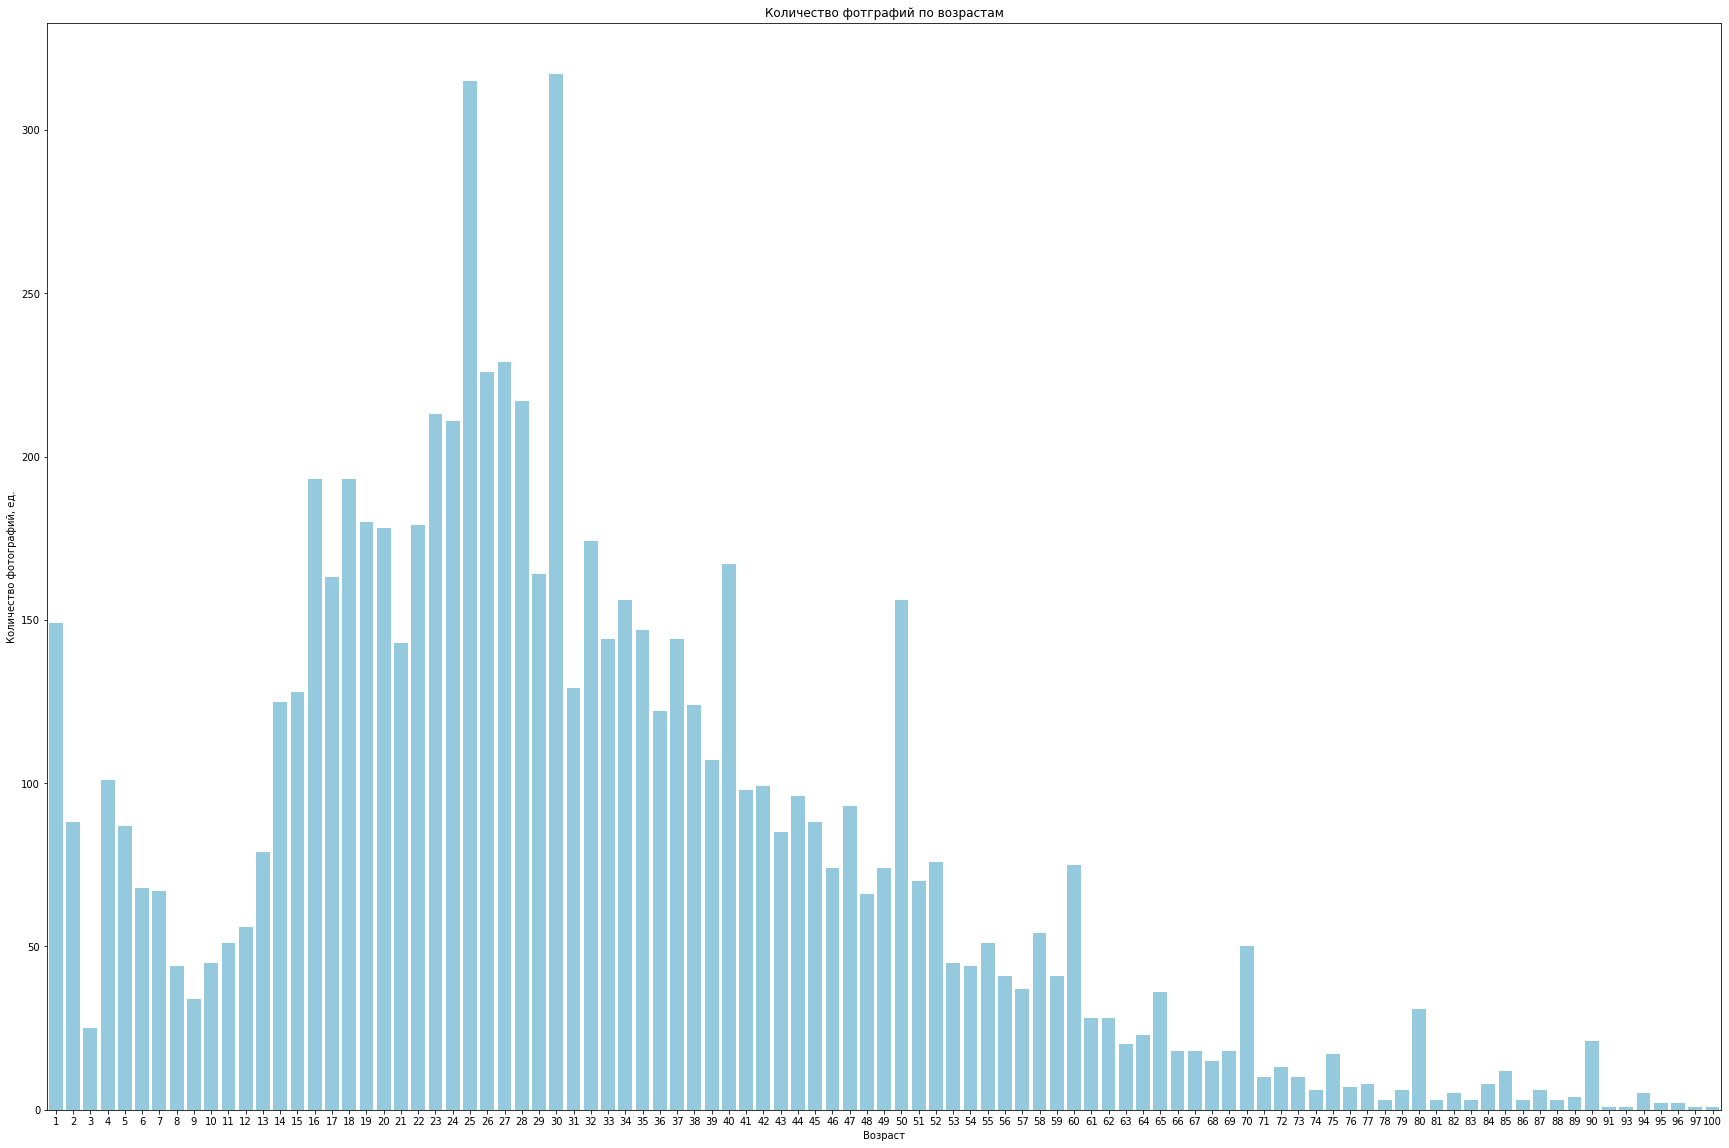

In [4]:
#диаграмма с количеством фотографий по возрастам
plt.figure(figsize=(30,20))
sns.barplot(
    x=labels['real_age'].value_counts().sort_index().index, 
    y=labels['real_age'].value_counts().sort_index().values, 
    color='skyblue').set_title('Количество фотграфий по возрастам')
plt.xlabel('Возраст')
plt.ylabel('Количество фотографий, ед.');

<AxesSubplot:>

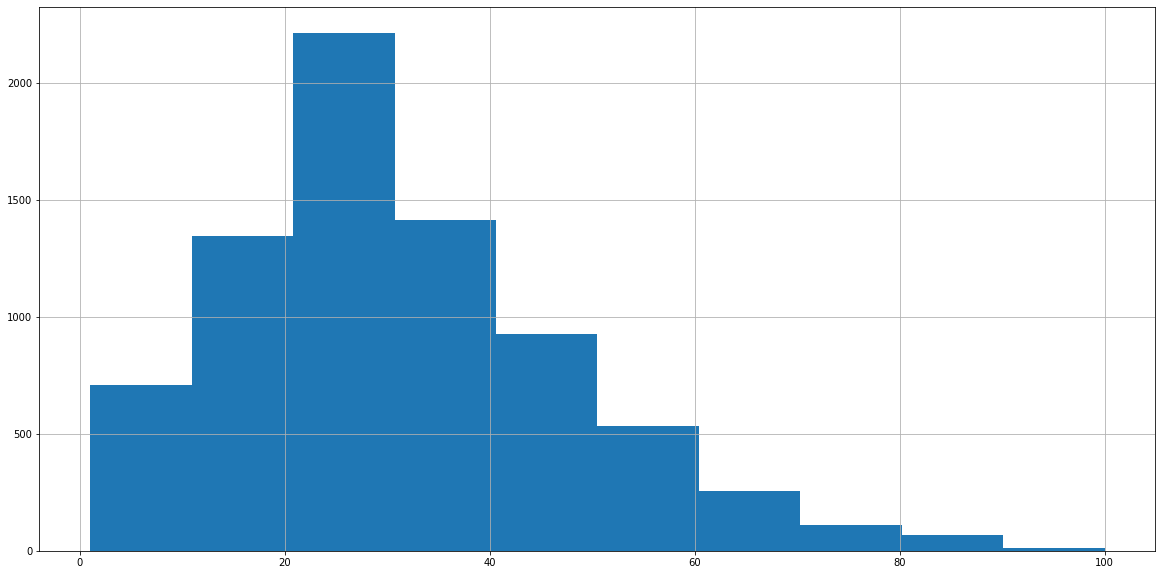

In [5]:
#распределение возрастов
plt.figure(figsize=(20,10))
labels['real_age'].hist()

In [6]:
#статистические данные по возрастам
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Text(0.5, 6.79999999999999, 'Количество фотографий')

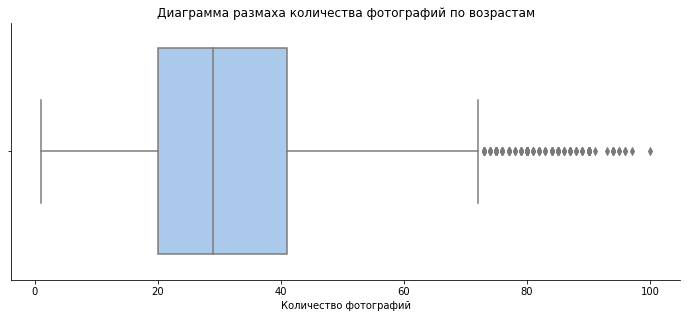

In [7]:
#диаграмма размаха
g = sns.catplot(x='real_age', kind="box", data=labels, orient='h', palette = 'pastel')
g.fig.set_figwidth(10)
g.fig.set_figheight(4)
plt.title('Диаграмма размаха количества фотографий по возрастам')
plt.xlabel('Количество фотографий')

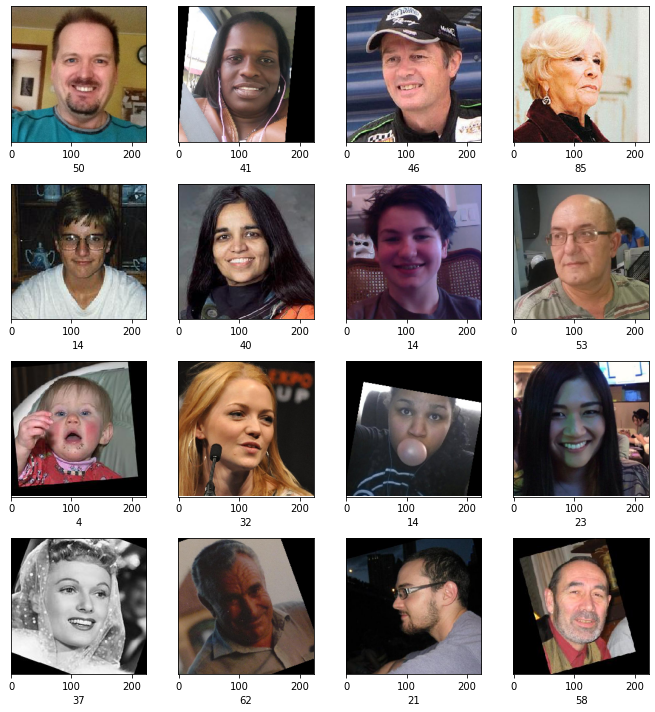

In [8]:
#выведем 16 фотографий на экран
features, target = next(train_datagen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xlabel(target[i])
    plt.yticks([])
    plt.tight_layout()


**Выводы:** 
1. Выборка содержит данные о возрасте людей на 7591 фотографиях разного качества. Этого количества недостаточно для обучения нейронных сетей, при загрузке данных для обучения моделей необходимо будет применить аугментацию.
2. Поскольку выборка состоит из фотографий людей, нам точно не подойдут повороты и отражения по-вертикали. Лица на выведенных фотографиях расположены близко к центру и достаточно крупно. Учитывая это, можем себе позводить отражение по-горизонтали, небольшое смещение по вертикали и горизонтали (10-20%), изменение яркости, небольшое приближение (10-20%).
3. Самое большое количество фотографий приходится на возраст от 20 до 30 лет, знаечние медианы близко к значению среднего, распределение на гистограмме выглядит похожим на нормальное. Выборка немного растянута в сторону увеличения возраста (максимальное значение - 100 лет), данные начиная примерно с 75 лет можно счесть выбросами, но в целом такое распределение логично, потому что до такого возраста доживает не такое уж большое количество людей и не все они готовы размещать свои фотографии в доступных источниках.
4. В выборке присутствует достаточно больше количество фотографий детей (до 12 лет - 815 фотографий, т.е. более 10% выборки), причем больше всего - в возрасте 1 года. Вероятно из-за любви родителей выкладывать в сеть фотографии младенцев. Поскольку дети такого возраста вряд ли будут самостоятельно делать покупки, обучать модели на таких данных бессмысленно. А вот для подростков это будет актуально из-за ограничений на покупку ряда товаров несовершеннолетними.

## Подбор и обучение моделей

In [21]:
#импортируем библиотеки для моделей
import sklearn
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np

### Baseline модель

In [ ]:
# в качестве константной модели для задачи регрессии используем модель, предсказывающую медианное значение
labels = pd.read_csv('/datasets/faces/labels.csv')
target = labels['real_age']
predictions = pd.Series(labels['real_age'].median(), index=labels.index)
mae_baseline = mean_absolute_error(target,predictions)
print('baseline mae:', mae_baseline)

 Делала отдельно в тренажёре, поэтому ответ модели текстом:
 baseline mae: 13.11987880384666

In [22]:
mae_baseline = round(13.11987880384666,4)

### Алгоритм LeNet

Для начала попробуем алгоритм LeNet с 2мя свёрточными слоями. Выполнялся в тренажёре.

####  Без аугментации

In [ ]:
def load_test(path):
        
    test_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
               
    dataframe = pd.read_csv(path + 'labels.csv'),
    directory= (path + '/final_files'),   
    
    x_col='file_name',
    y_col='real_age',   
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)
    
    return test_datagen_flow
 
def load_train(path):
    
    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
              
    dataframe = pd.read_csv(path + 'labels.csv'),
    directory= (path + '/final_files'),
     
    x_col='file_name',
    y_col='real_age',  
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345)
    
    return train_datagen_flow
 
 
def create_model(input_shape):
    
    model = Sequential()
    optimizer = Adam(lr=0.0001)
    
    model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='same', activation="relu", input_shape=input_shape))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='valid', activation="relu"))
    model.add(AvgPool2D(pool_size=(2, 2), strides=None, padding='valid'))      
    model.add(Flatten()) 
    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=3, steps_per_epoch=None,validation_steps=None):
  model.fit(train_data, 
            validation_data = test_data, 
            batch_size=batch_size, 
            epochs=epochs, 
            steps_per_epoch=steps_per_epoch, 
            validation_steps=validation_steps,
            verbose=2)
  return model

In [23]:
mae_ln = 11.0142

#### С аугментацией

In [ ]:
def load_test(path):
        
    test_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
               
    dataframe = pd.read_csv(path + 'labels.csv'),
    directory= (path + '/final_files'),   
    
    x_col='file_name',
    y_col='real_age',   
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)
    
    return test_datagen_flow
 
def load_train(path):
    
    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
              
    dataframe = pd.read_csv(path + 'labels.csv'),
    directory= (path + '/final_files'),
     
    x_col='file_name',
    y_col='real_age',  
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.3,1.0),    
    seed=12345)
    
    return train_datagen_flow
 
 
def create_model(input_shape):
    
    model = Sequential()
    optimizer = Adam(lr=0.0001)
    
    model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='same', activation="relu", input_shape=input_shape))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='valid', activation="relu"))
    model.add(AvgPool2D(pool_size=(2, 2), strides=None, padding='valid'))      
    model.add(Flatten()) 
    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=3, steps_per_epoch=None,validation_steps=None):
  model.fit(train_data, 
            validation_data = test_data, 
            batch_size=batch_size, 
            epochs=epochs, 
            steps_per_epoch=steps_per_epoch, 
            validation_steps=validation_steps,
            verbose=2)
  return model

In [24]:
mae_ln_aug = 11.1657

### Алгоритм ResNet

#### Без аугментации

In [ ]:
def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + '/labels.csv'), 
        directory=(path + '/final_files'),  
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + '/labels.csv'),
        directory=(path + '/final_files'),  
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_datagen_flow

def create_model(input_shape):
    model = Sequential()
    backbone = ResNet50(input_shape=input_shape,
                       weights = '/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', #'imagenet', # 
                      include_top=False)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(loss='mse', optimizer=optimizer,  metrics=['mae']) 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None,validation_steps=None):
    model.fit(train_data, 
            validation_data = test_data, 
            batch_size=batch_size, 
            epochs=epochs, 
            steps_per_epoch=steps_per_epoch, 
            validation_steps=validation_steps,
            verbose=2)
    return model

In [25]:
mae_rn_noaug = 6.2531

#### C аугментацией

In [ ]:
# выбраны параметры аугментации, дающие лучшую mae, аналогично с lr
def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + '/labels.csv'), 
        directory=(path + '/final_files'),  
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        brightness_range=(0.3,1.0),
        seed=12345) 
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + '/labels.csv'), 
        directory=(path + '/final_files'), 
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_datagen_flow

def create_model(input_shape):
    model = Sequential()
    backbone = ResNet50(input_shape=input_shape,
                       weights = '/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', #'imagenet', # 
                      include_top=False)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(loss='mse', optimizer=optimizer,  metrics=['mae']) 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None,validation_steps=None):
    model.fit(train_data, 
            validation_data = test_data, 
            batch_size=batch_size, 
            epochs=epochs, 
            steps_per_epoch=steps_per_epoch, 
            validation_steps=validation_steps,
            verbose=2)
    return model

In [26]:
mae_rn_aug = 6.1467 

Добавление аугментации и подбор её параметров даёт улучшение метрики в 2 раза.

### Алгоритм Inception

#### Без аугментации

In [ ]:
def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + '/labels.csv'), 
        directory=(path + '/final_files'),  
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + '/labels.csv'), 
        directory=(path + '/final_files'),  
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_datagen_flow

def create_model(input_shape):
    model = Sequential()
    backbone = InceptionV3(input_shape=input_shape, 
                       weights = 'imagenet', 
                      include_top=False)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(loss='mse', optimizer=optimizer,  metrics=['mae']) 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None,validation_steps=None):
    model.fit(train_data, 
            validation_data = test_data, 
            batch_size=batch_size, 
            epochs=epochs, 
            steps_per_epoch=steps_per_epoch, 
            validation_steps=validation_steps,
            verbose=2)
    return model

In [27]:
mae_int_noaug = 6.6039

#### С аугментацией

In [ ]:
 def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + '/labels.csv'), 
        directory=(path + '/final_files'),  
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        brightness_range=(0.3,1.0),
        seed=12345) 
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + '/labels.csv'), 
        directory=(path + '/final_files'), 
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.3,
        brightness_range=(0.5,1.0),
        seed=12345) 
    return test_datagen_flow

def create_model(input_shape):
    model = Sequential()
    backbone = InceptionV3(input_shape=input_shape, 
                       weights = 'imagenet', 
                      include_top=False)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(loss='mse', optimizer=optimizer,  metrics=['mae']) 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None,validation_steps=None):
    model.fit(train_data, 
            validation_data = test_data, 
            batch_size=batch_size, 
            epochs=epochs, 
            steps_per_epoch=steps_per_epoch, 
            validation_steps=validation_steps,
            verbose=2)
    return model

In [28]:
mae_int_aug = 6.2597

## Анализ моделей и общий вывод

In [29]:
results = pd.DataFrame({'models':['Baseline', 'LeNet', 'ResNet', 'Inception'],
                      'no_augmentation':[mae_baseline, mae_ln, mae_rn_noaug, mae_int_noaug],
                      'augmentation':[mae_baseline, mae_ln_aug, mae_rn_aug, mae_int_aug]})
display(results)

,models,no_augmentation,augmentation
0,Baseline,13.1199,13.1199
1,LeNet,11.0142,11.1657
2,ResNet,6.2531,6.1467
3,Inception,6.6039,6.2597


У всех моделей результаты получились лучше, чем у константной.  
При этом алгоритм LeNet не позволил достичь целевое знаечние mae.  
У ResNet и Inception получились очень близкие результаты, но у ResNet на 0,1 лучше.  
Результаты на выборке с аугментацией и у ResNet, и у Inception получились лучше, чем без, хотя разница не очень значительная.  
В качестве параметров аугментации подобраны подходящие под характеристика датасета:  
  * width_shift_range=0.1 - сдвиг по ширине на 10%,
  * height_shift_range=0.1 - сдвиг по высоте на 10%,
  * zoom_range=0.1 - увеличение на 10%,
  * brightness_range=(0.3,1.0) - уменьшение яркости до 30%.